# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- 18/0013637 Arthur Paiva Tavares
- 17/0031538 Dâmaso Júnio pereira Brasileo
- 18/0063723 Fellipe dos Santos Araujo
- 15/0135939 Letícia Karla Araújo
- 20/0057227 Caio Vitor de Oliveira
- 20/0036351 Clara Marcelino de Sousa
- 20/0030469 Felipe Candido de Moura
- 19/0091720 Lucas macedo Barboza
- 20/0023411 Luíza Esteves dos Santos
- 20/0041959 Maurício Machado Filho
- 19/0037806 Samuel Furtado Avila

### LIBRARIES

In [46]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [47]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [48]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [49]:
jsons = glob('../analytics-raw-data/*.json') # add the path here
print(len(jsons))

8


In [50]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Eu-Pescador-(.*?)-(.*?)-(.*?)-(.*?)-(.*?):(.*?):(.*?)-v(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [51]:
base_component_df = create_base_component_df(jsons)

In [52]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
48,duplicated_lines_density,0.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
49,functions,20,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
50,test_execution_time,122,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
51,test_failures,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
52,test_errors,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
53,security_rating,1.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
54,tests,23,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
55,files,8,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
56,complexity,46,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
57,ncloc,384,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03


#### Create dataframe per file

In [53]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [54]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours. 
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Eu-Pescador-(.*?)-(.*?)-(.*?)-(.*?)-(.*?):(.*?):(.*?)-v(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [55]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['FishLog', 'FishWiki', 'User', 'UserInterface'], dtype=object)

In [56]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,tests,test_errors,test_failures,test_execution_time,security_rating,filename,repository,version
109,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
110,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
111,src/config/database.ts,2,4,0.0,0.0,0.0,27,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
112,src/models/fishLog.ts,0,0,0.0,0.0,100.0,94,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
113,src/controllers/fishLogController.ts,8,29,0.0,0.0,84.7,186,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
114,src/routes/fishLogRoutes.ts,6,6,0.0,0.0,0.0,25,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
115,src/routes/router.ts,0,0,16.7,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
116,src/server.ts,1,2,0.0,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03
101,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishWiki-03-18-...,FishWiki,03
102,src/config/database.ts,2,4,0.0,0.0,0.0,29,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishWiki-03-18-...,FishWiki,03


#### Create dataframe per repository

In [57]:
repo1_df = file_component_df[file_component_df['repository'] == 'UserInterface']
repo2_df = file_component_df[file_component_df['repository'] == 'User']
repo3_df = file_component_df[file_component_df['repository'] == 'FishWiki']
repo4_df = file_component_df[file_component_df['repository'] == 'FishLog']

In [58]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [59]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [60]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [61]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [62]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [63]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [64]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [65]:
def create_metrics_df(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [66]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)

### Data visualization

- You must do this for each of your repositories

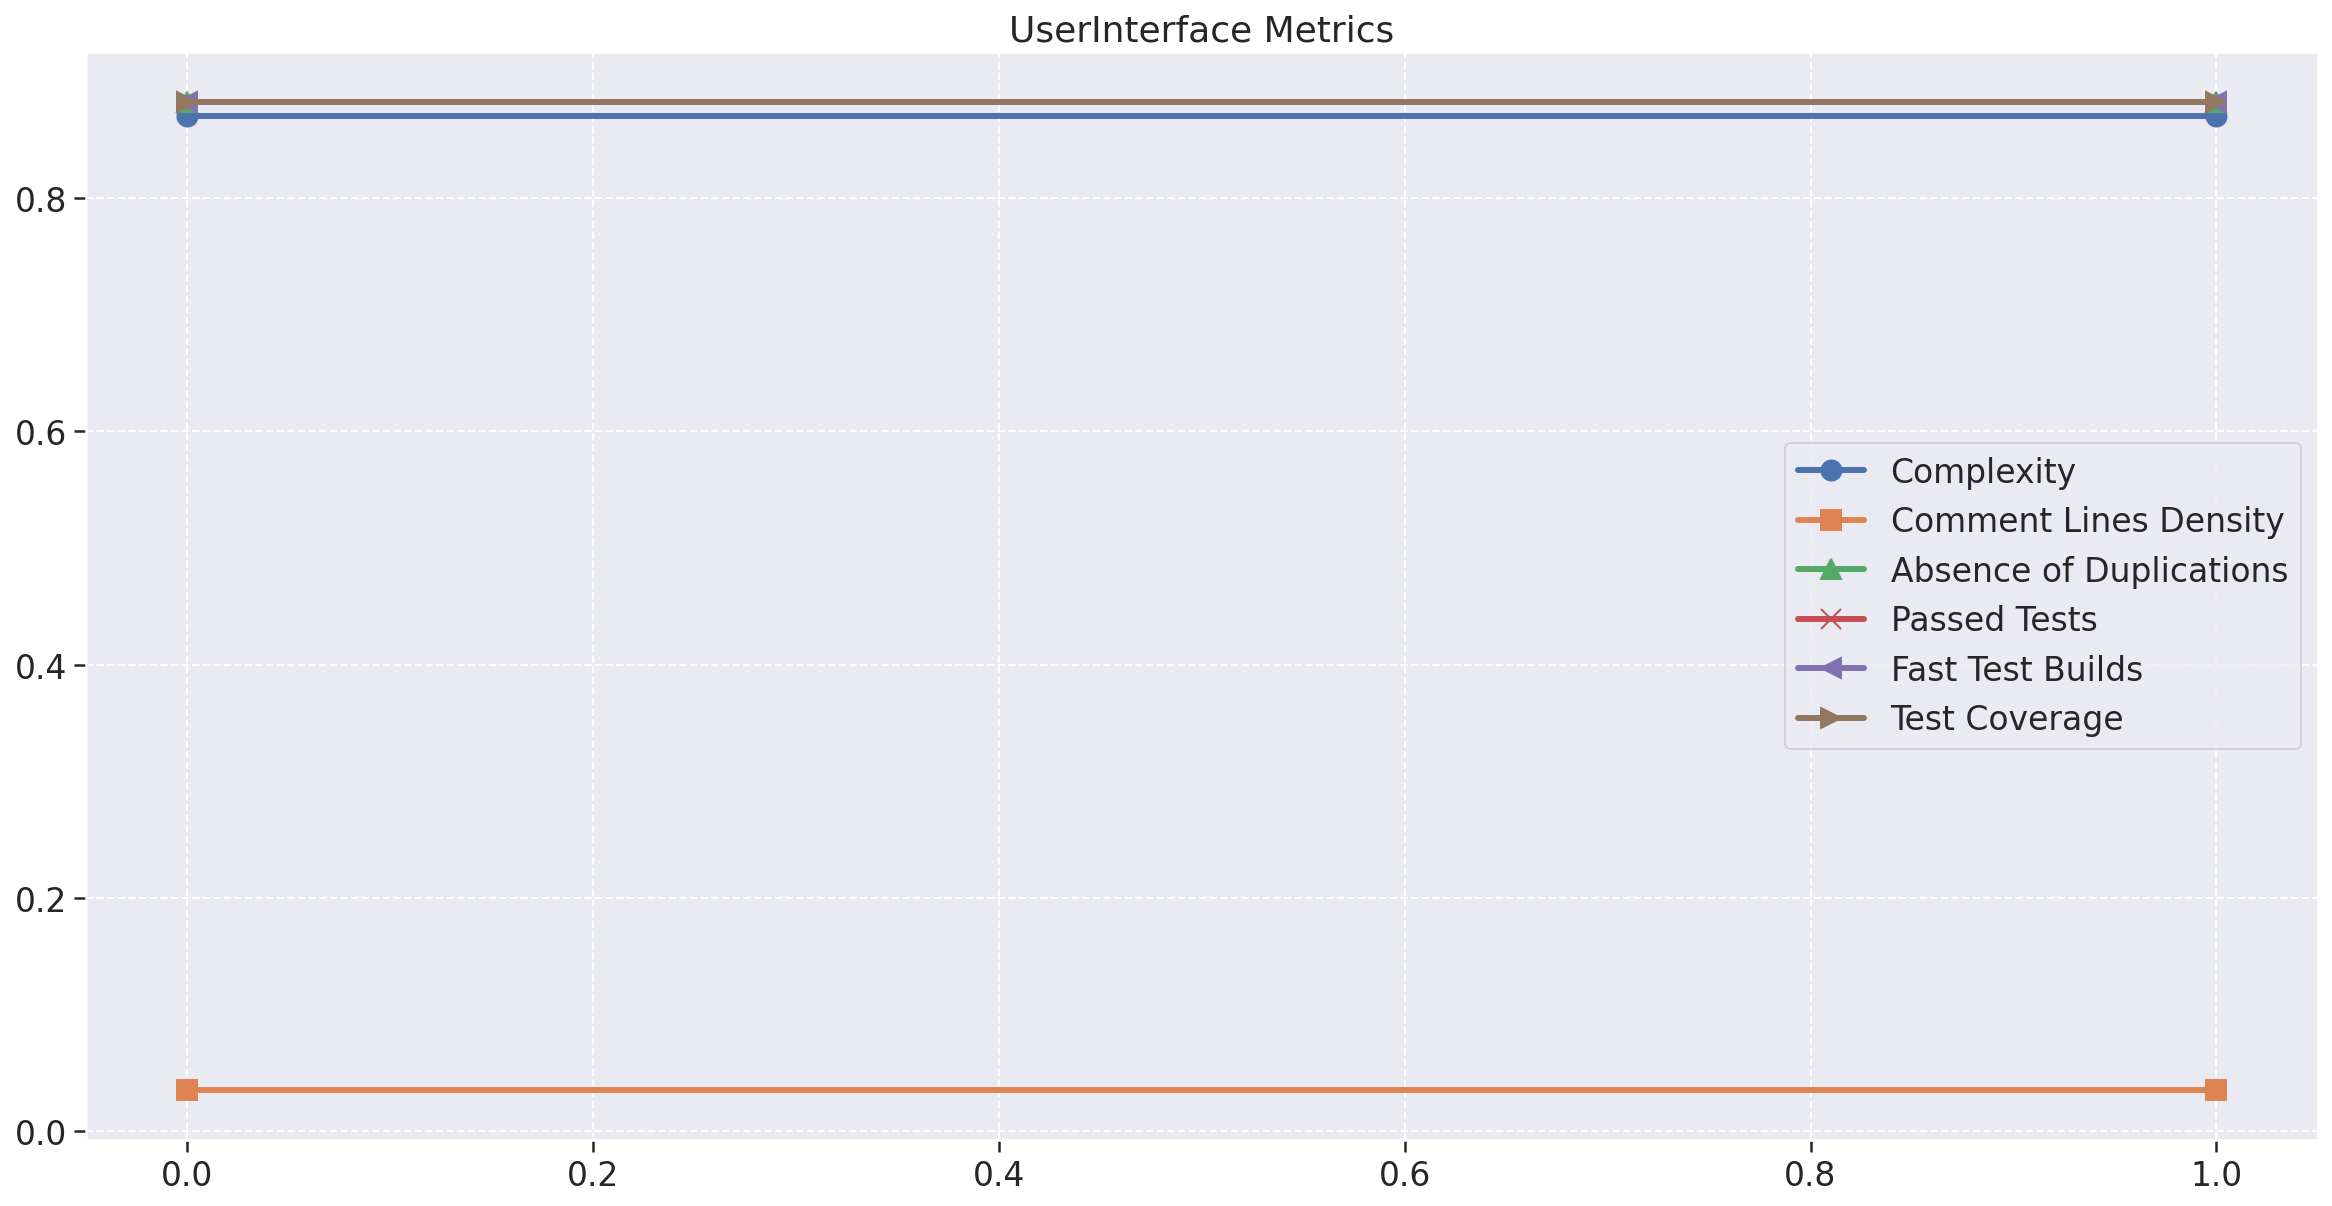

In [67]:
fig = plt.figure(figsize=(20, 10))

plt.title('UserInterface Metrics')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo1_metrics['m4'], linewidth=3, marker='x', label='Passed Tests', markersize=10)
plt.plot(repo1_metrics['m5'], linewidth=3, marker='<', label='Fast Test Builds', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

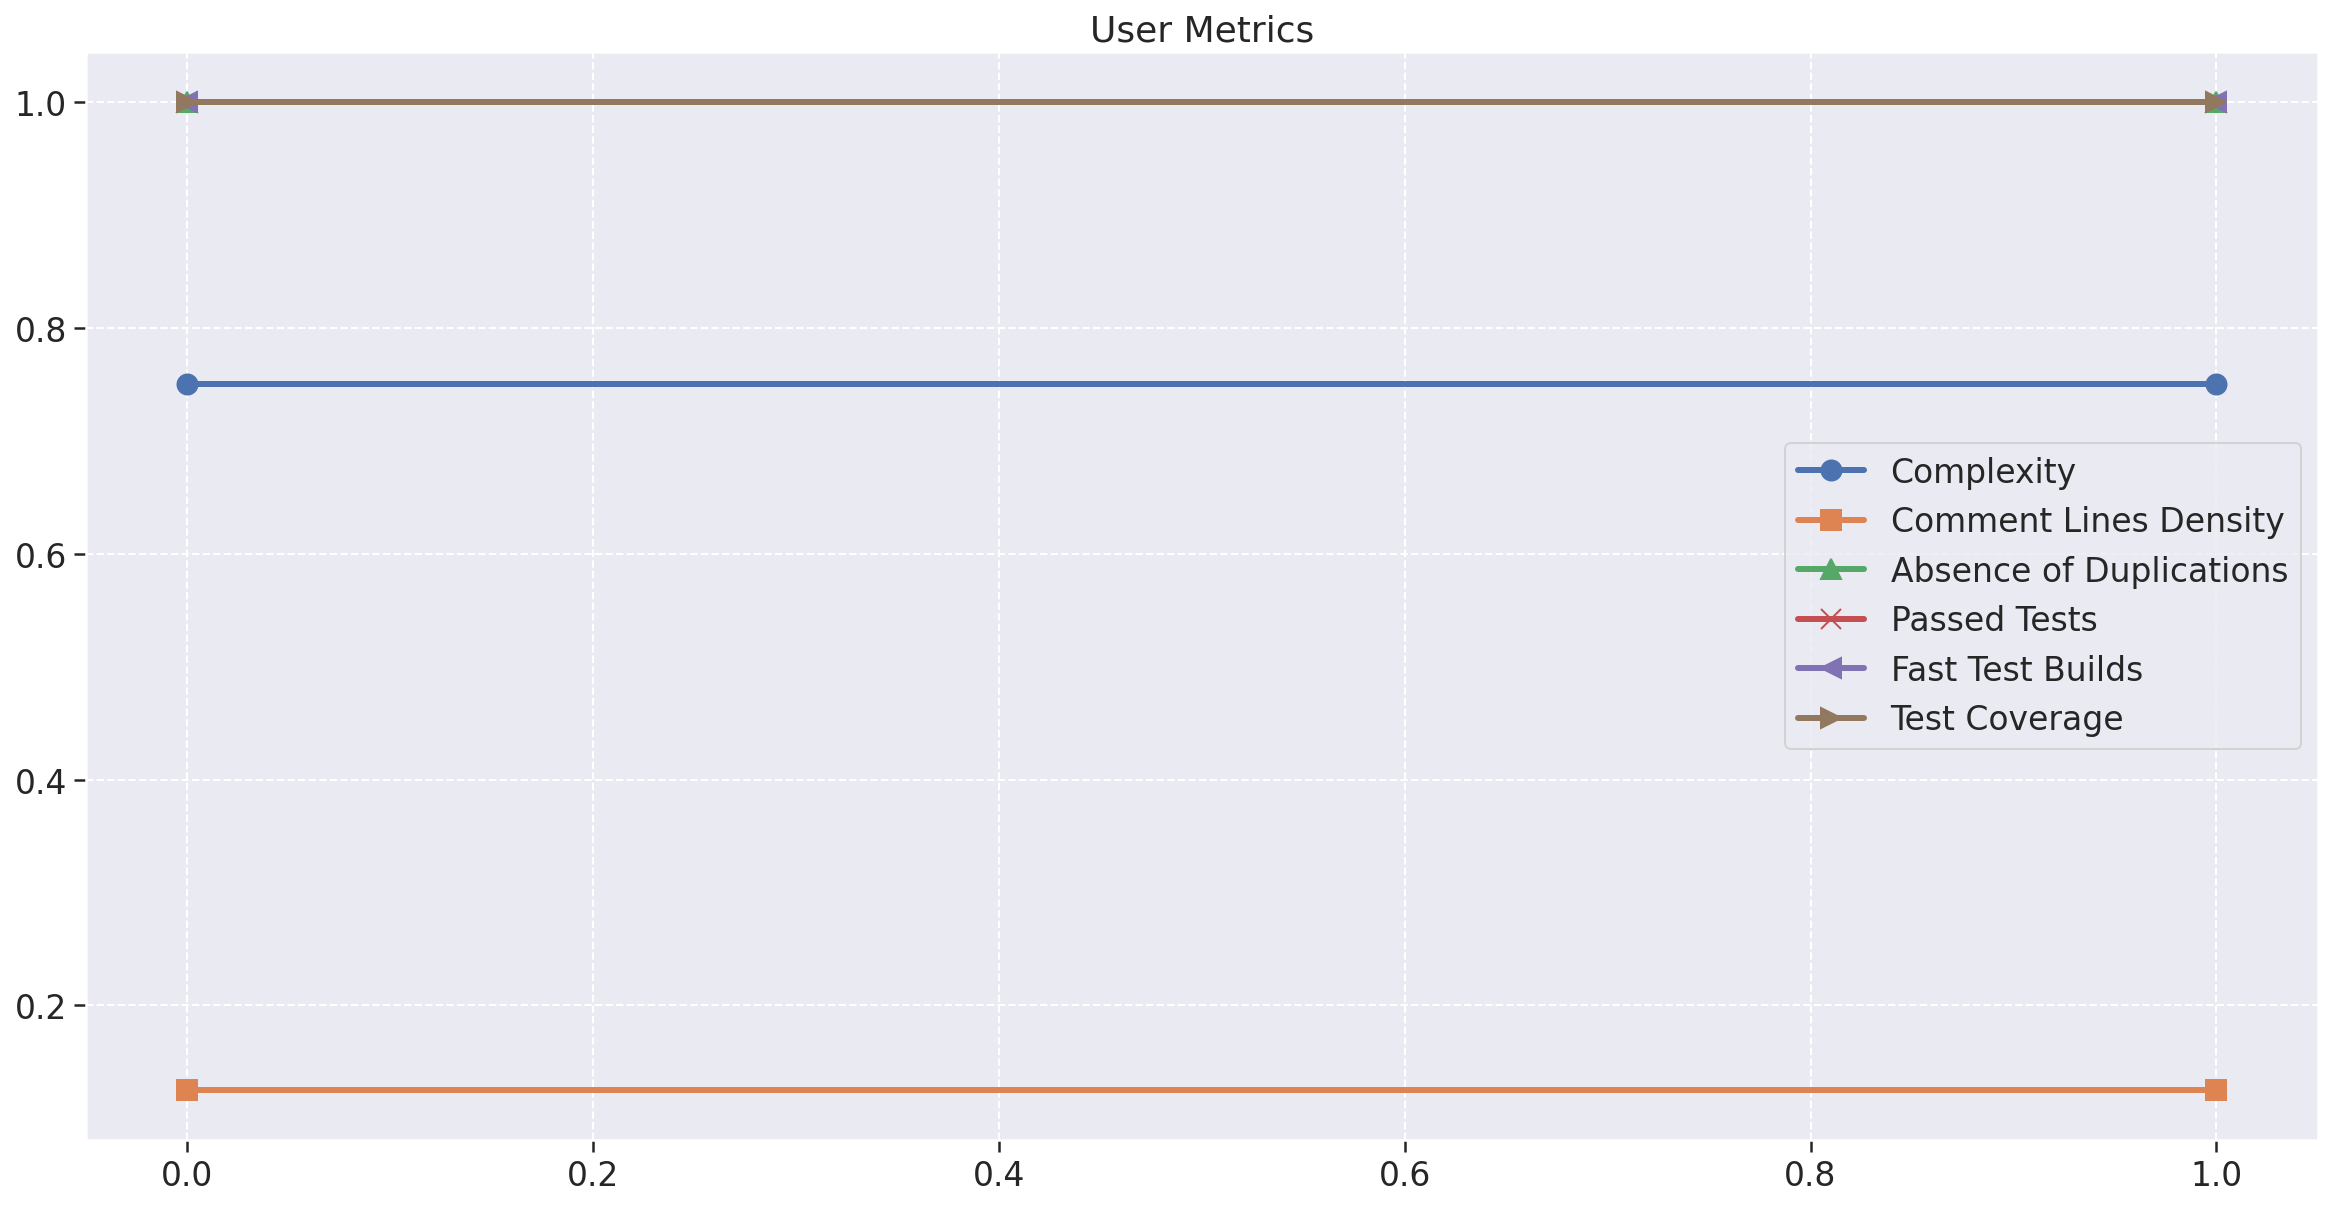

In [68]:
fig = plt.figure(figsize=(20, 10))

plt.title('User Metrics')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo2_metrics['m4'], linewidth=3, marker='x', label='Passed Tests', markersize=10)
plt.plot(repo2_metrics['m5'], linewidth=3, marker='<', label='Fast Test Builds', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

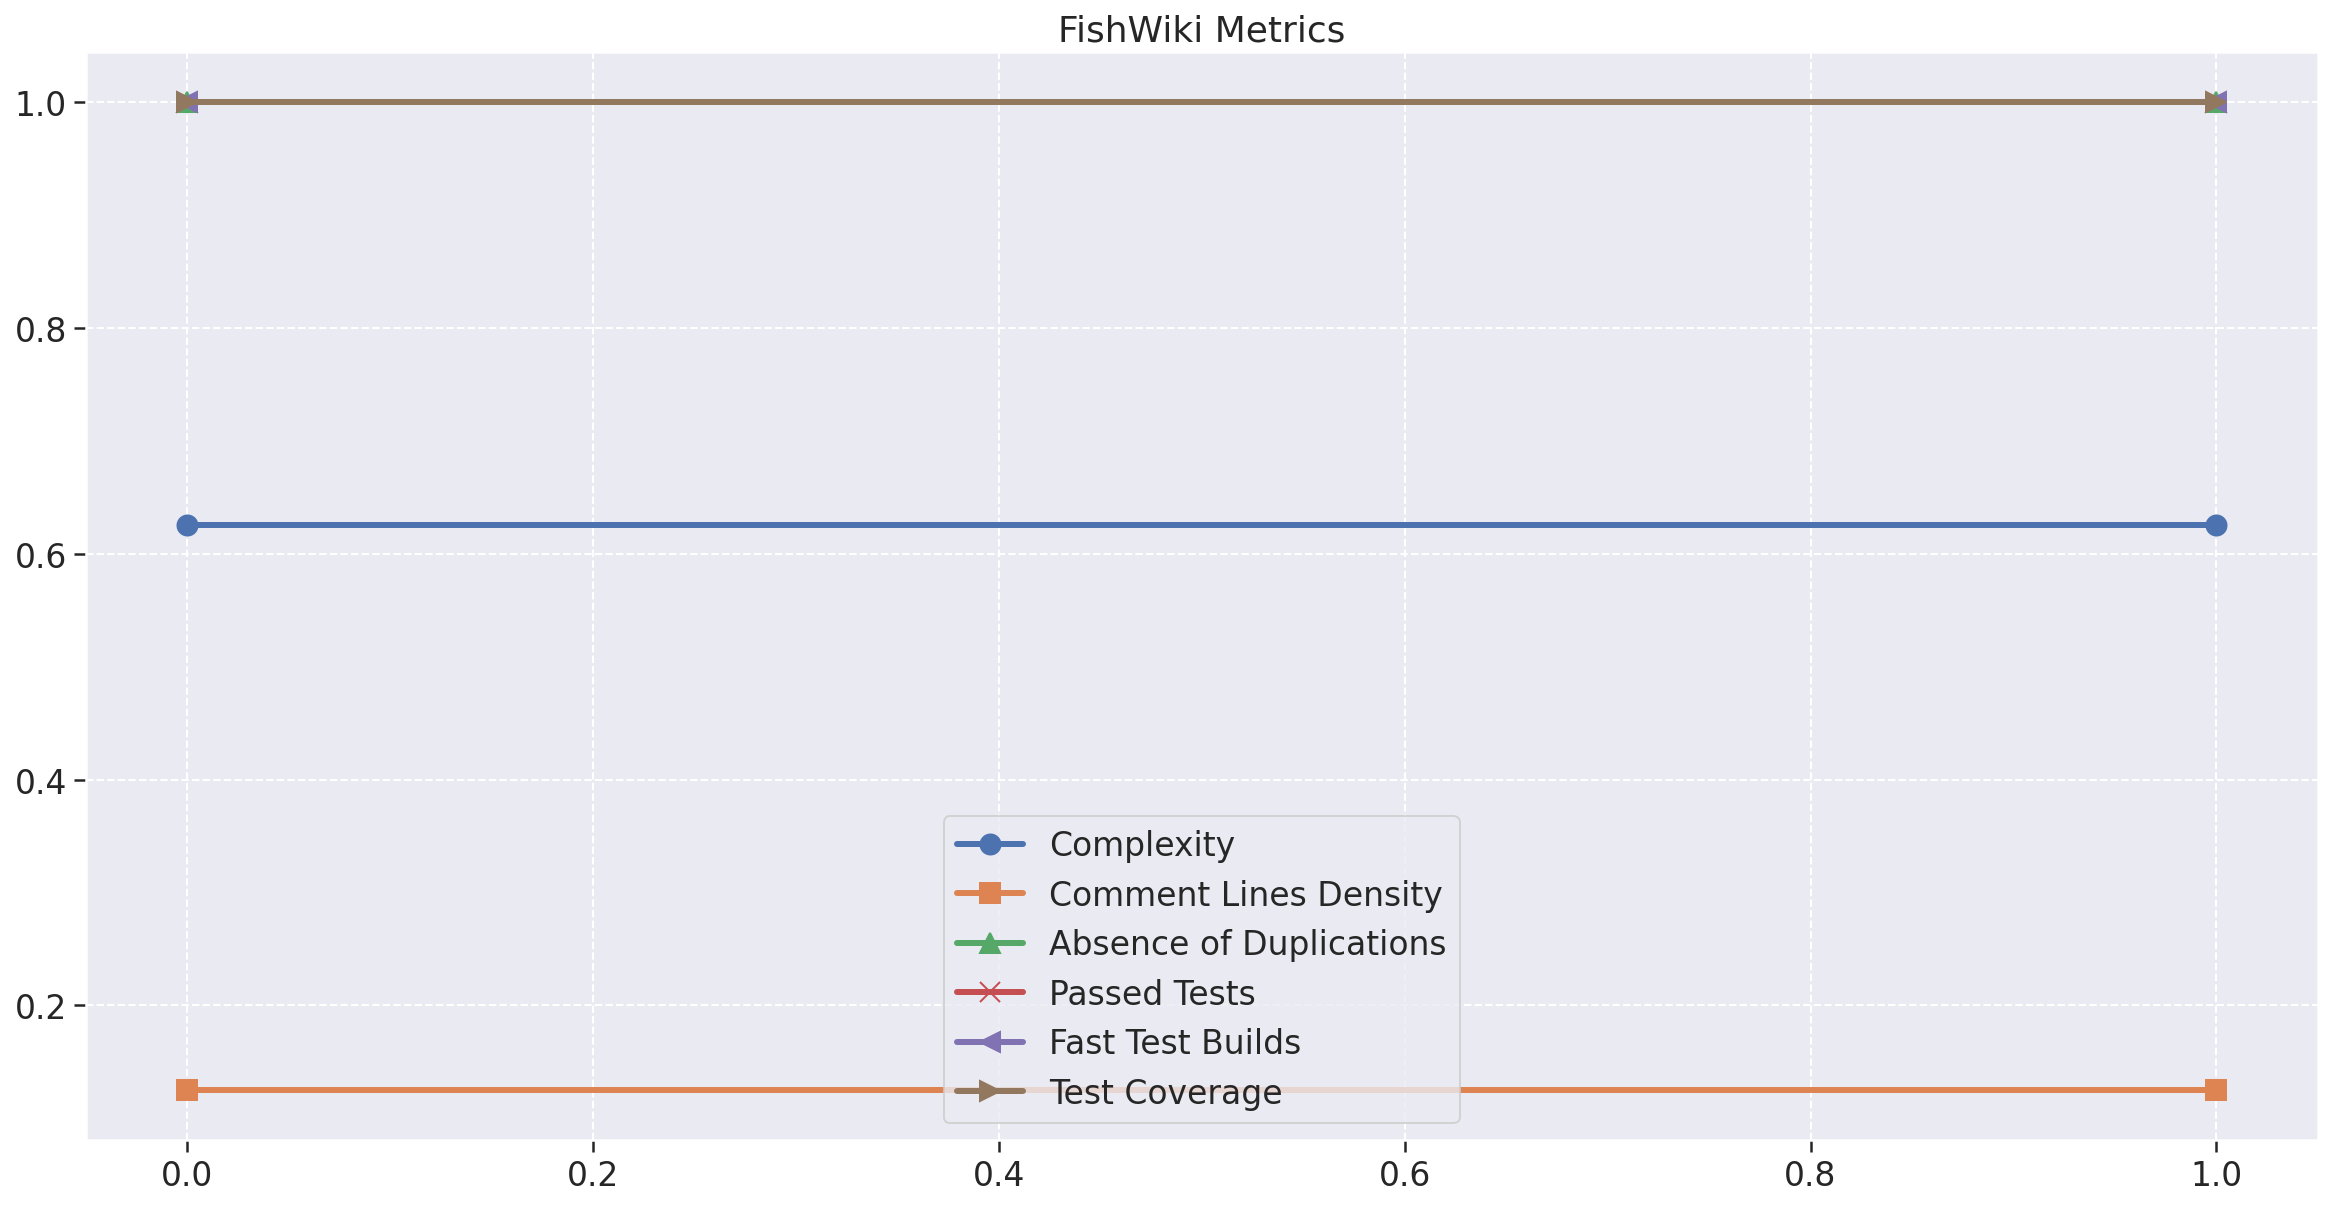

In [69]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishWiki Metrics')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo3_metrics['m4'], linewidth=3, marker='x', label='Passed Tests', markersize=10)
plt.plot(repo3_metrics['m5'], linewidth=3, marker='<', label='Fast Test Builds', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

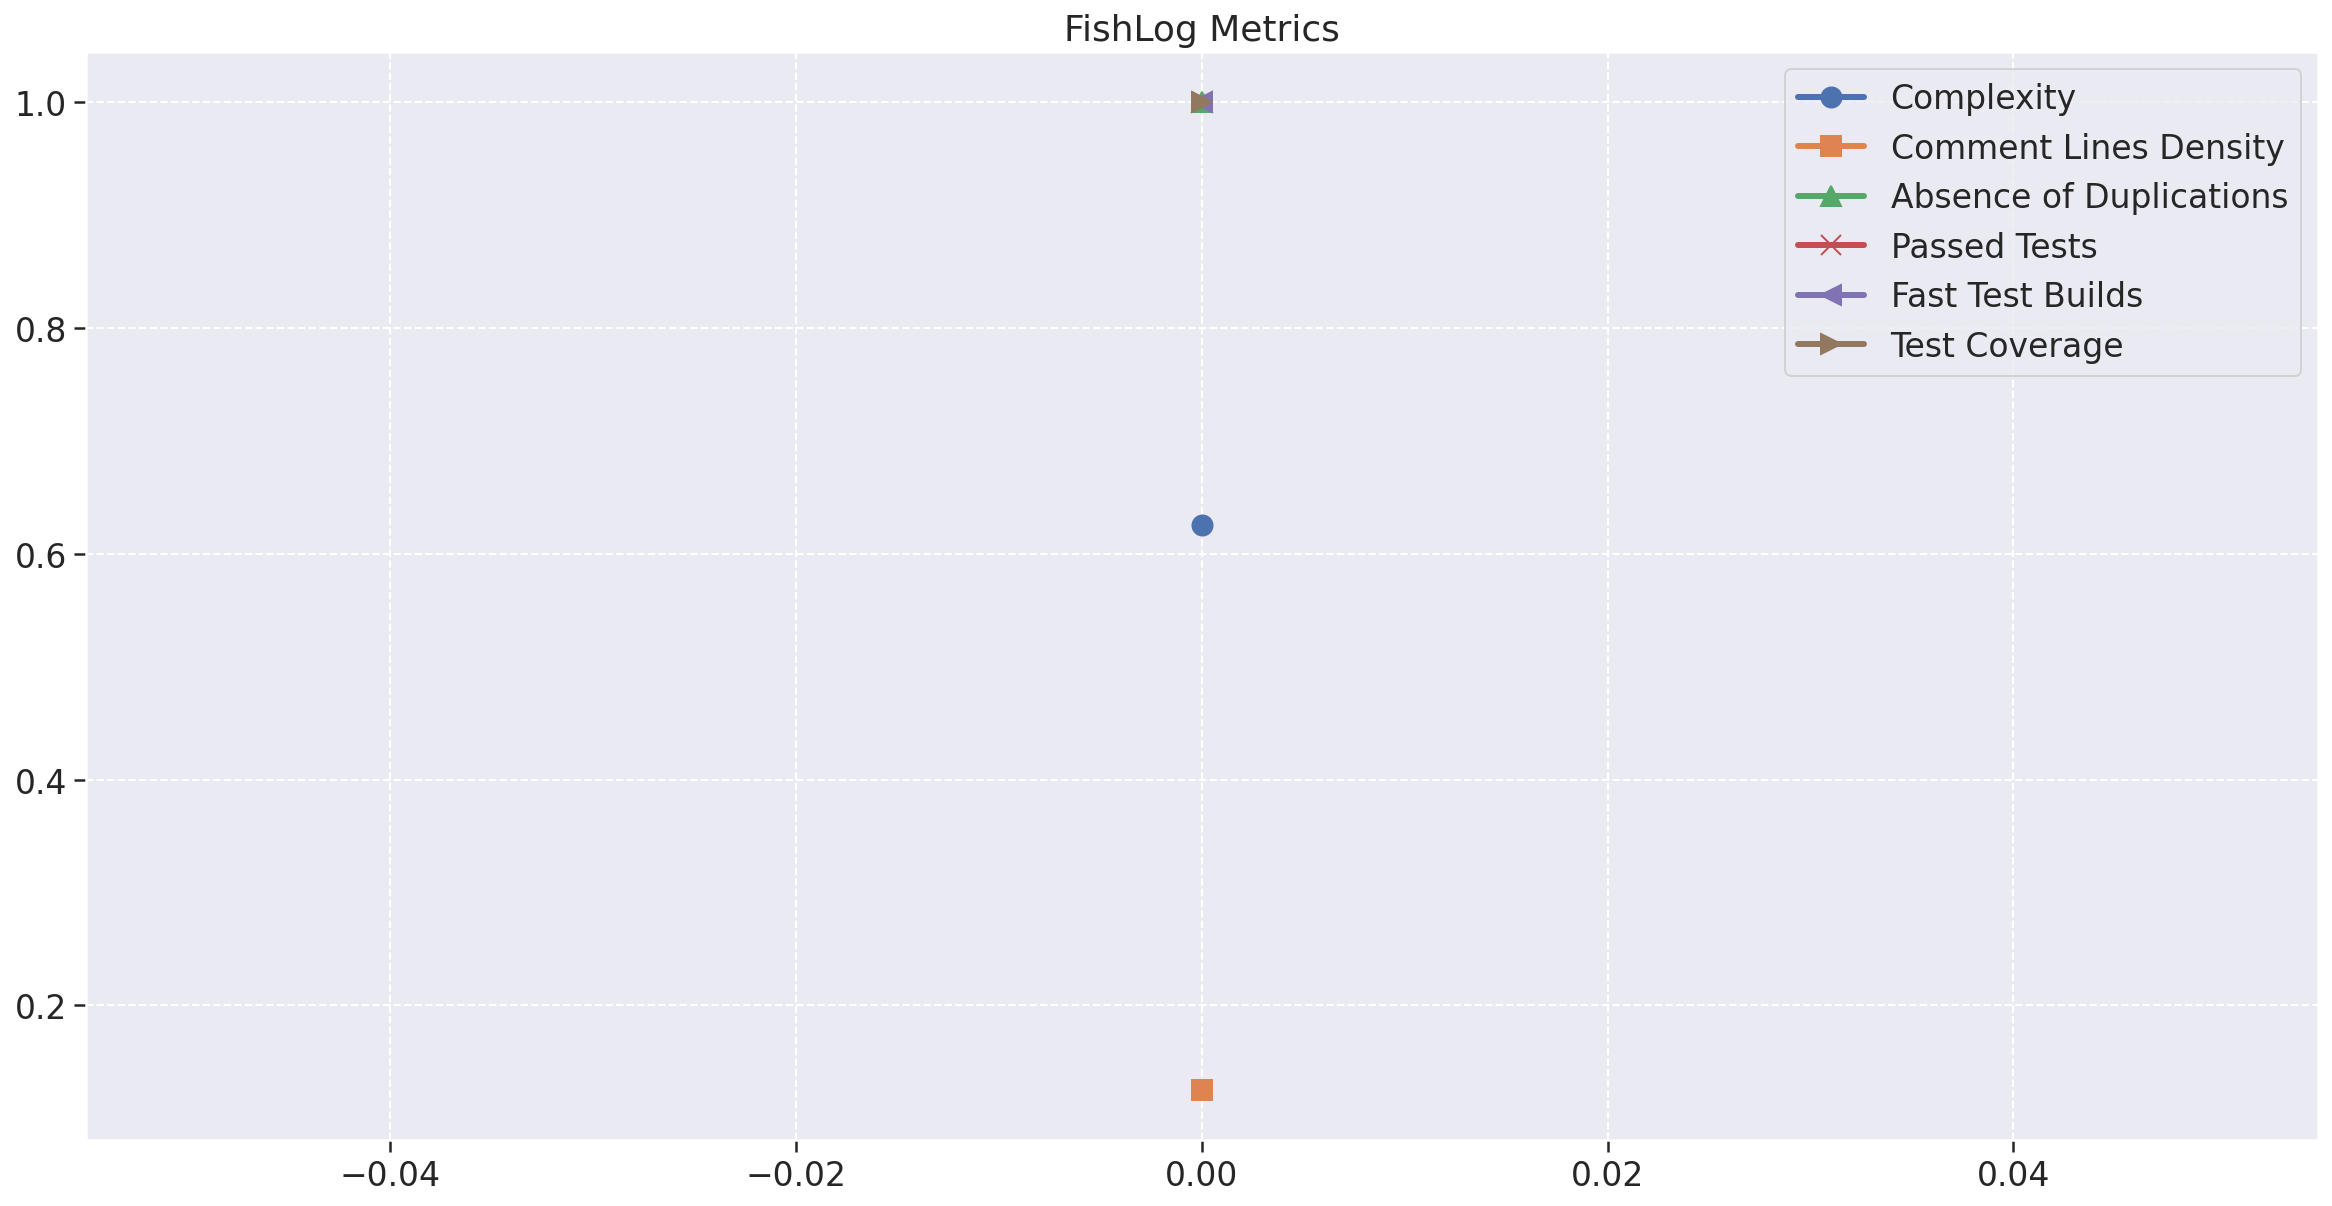

In [70]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog Metrics')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo4_metrics['m4'], linewidth=3, marker='x', label='Passed Tests', markersize=10)
plt.plot(repo4_metrics['m5'], linewidth=3, marker='<', label='Fast Test Builds', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [71]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = ((repo1_metrics['m4']*pm4) + (repo1_metrics['m5']*pm5) + (repo1_metrics['m6']*pm6)) * psc2
repo2_metrics['testing_status'] = ((repo2_metrics['m4']*pm4) + (repo2_metrics['m5']*pm5) + (repo2_metrics['m6']*pm6)) * psc2
repo3_metrics['testing_status'] = ((repo3_metrics['m4']*pm4) + (repo3_metrics['m5']*pm5) + (repo3_metrics['m6']*pm6)) * psc2
repo4_metrics['testing_status'] = ((repo4_metrics['m4']*pm4) + (repo4_metrics['m5']*pm5) + (repo4_metrics['m6']*pm6)) * psc2


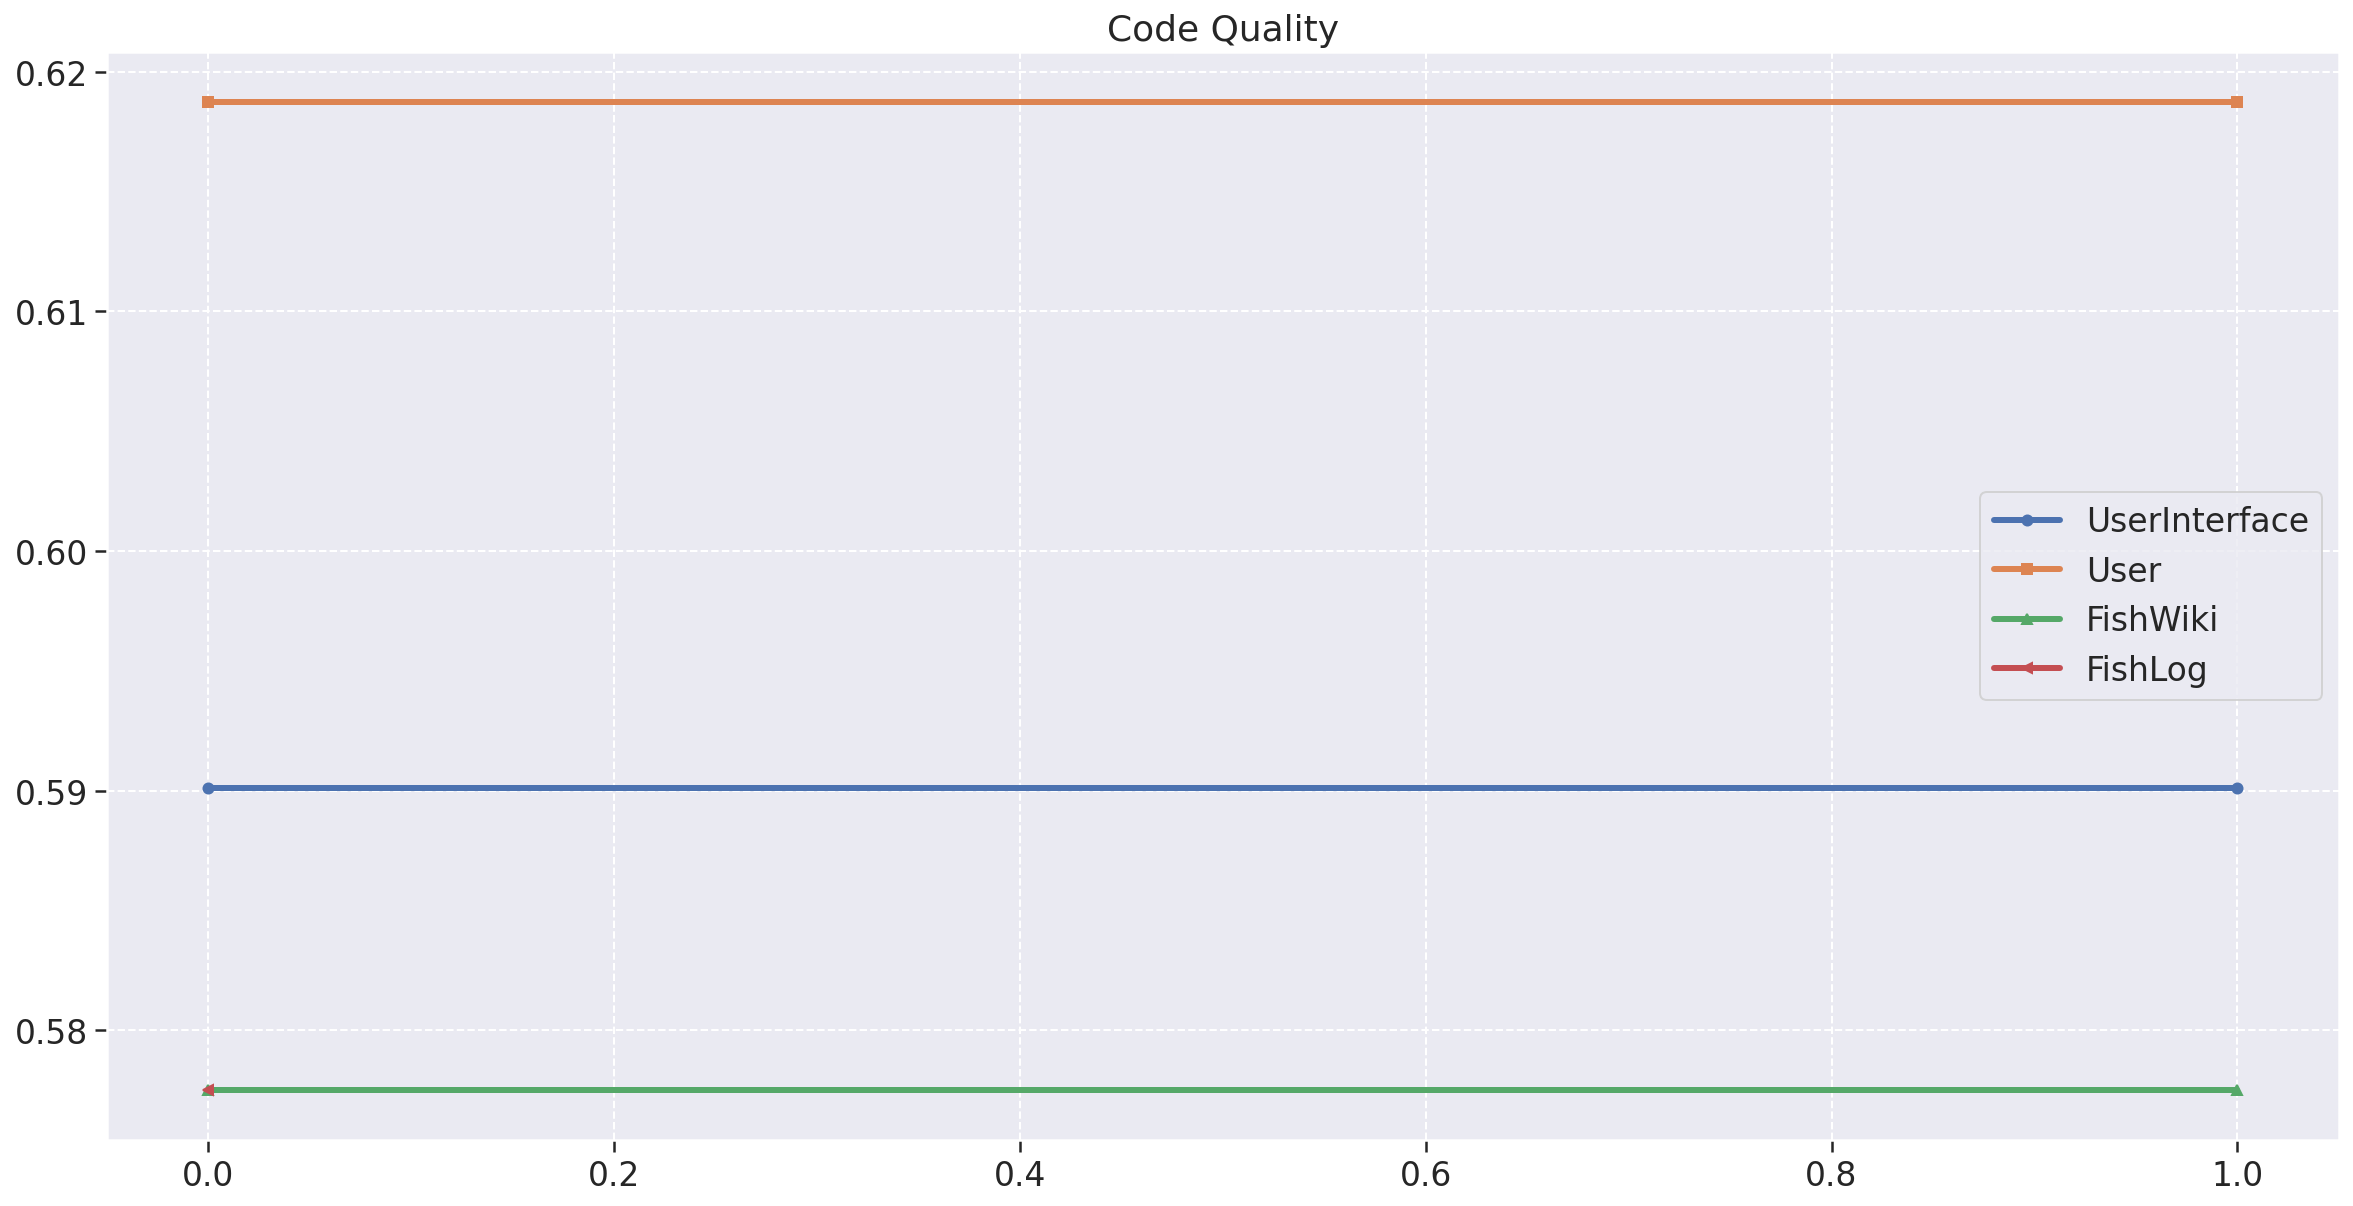

In [72]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

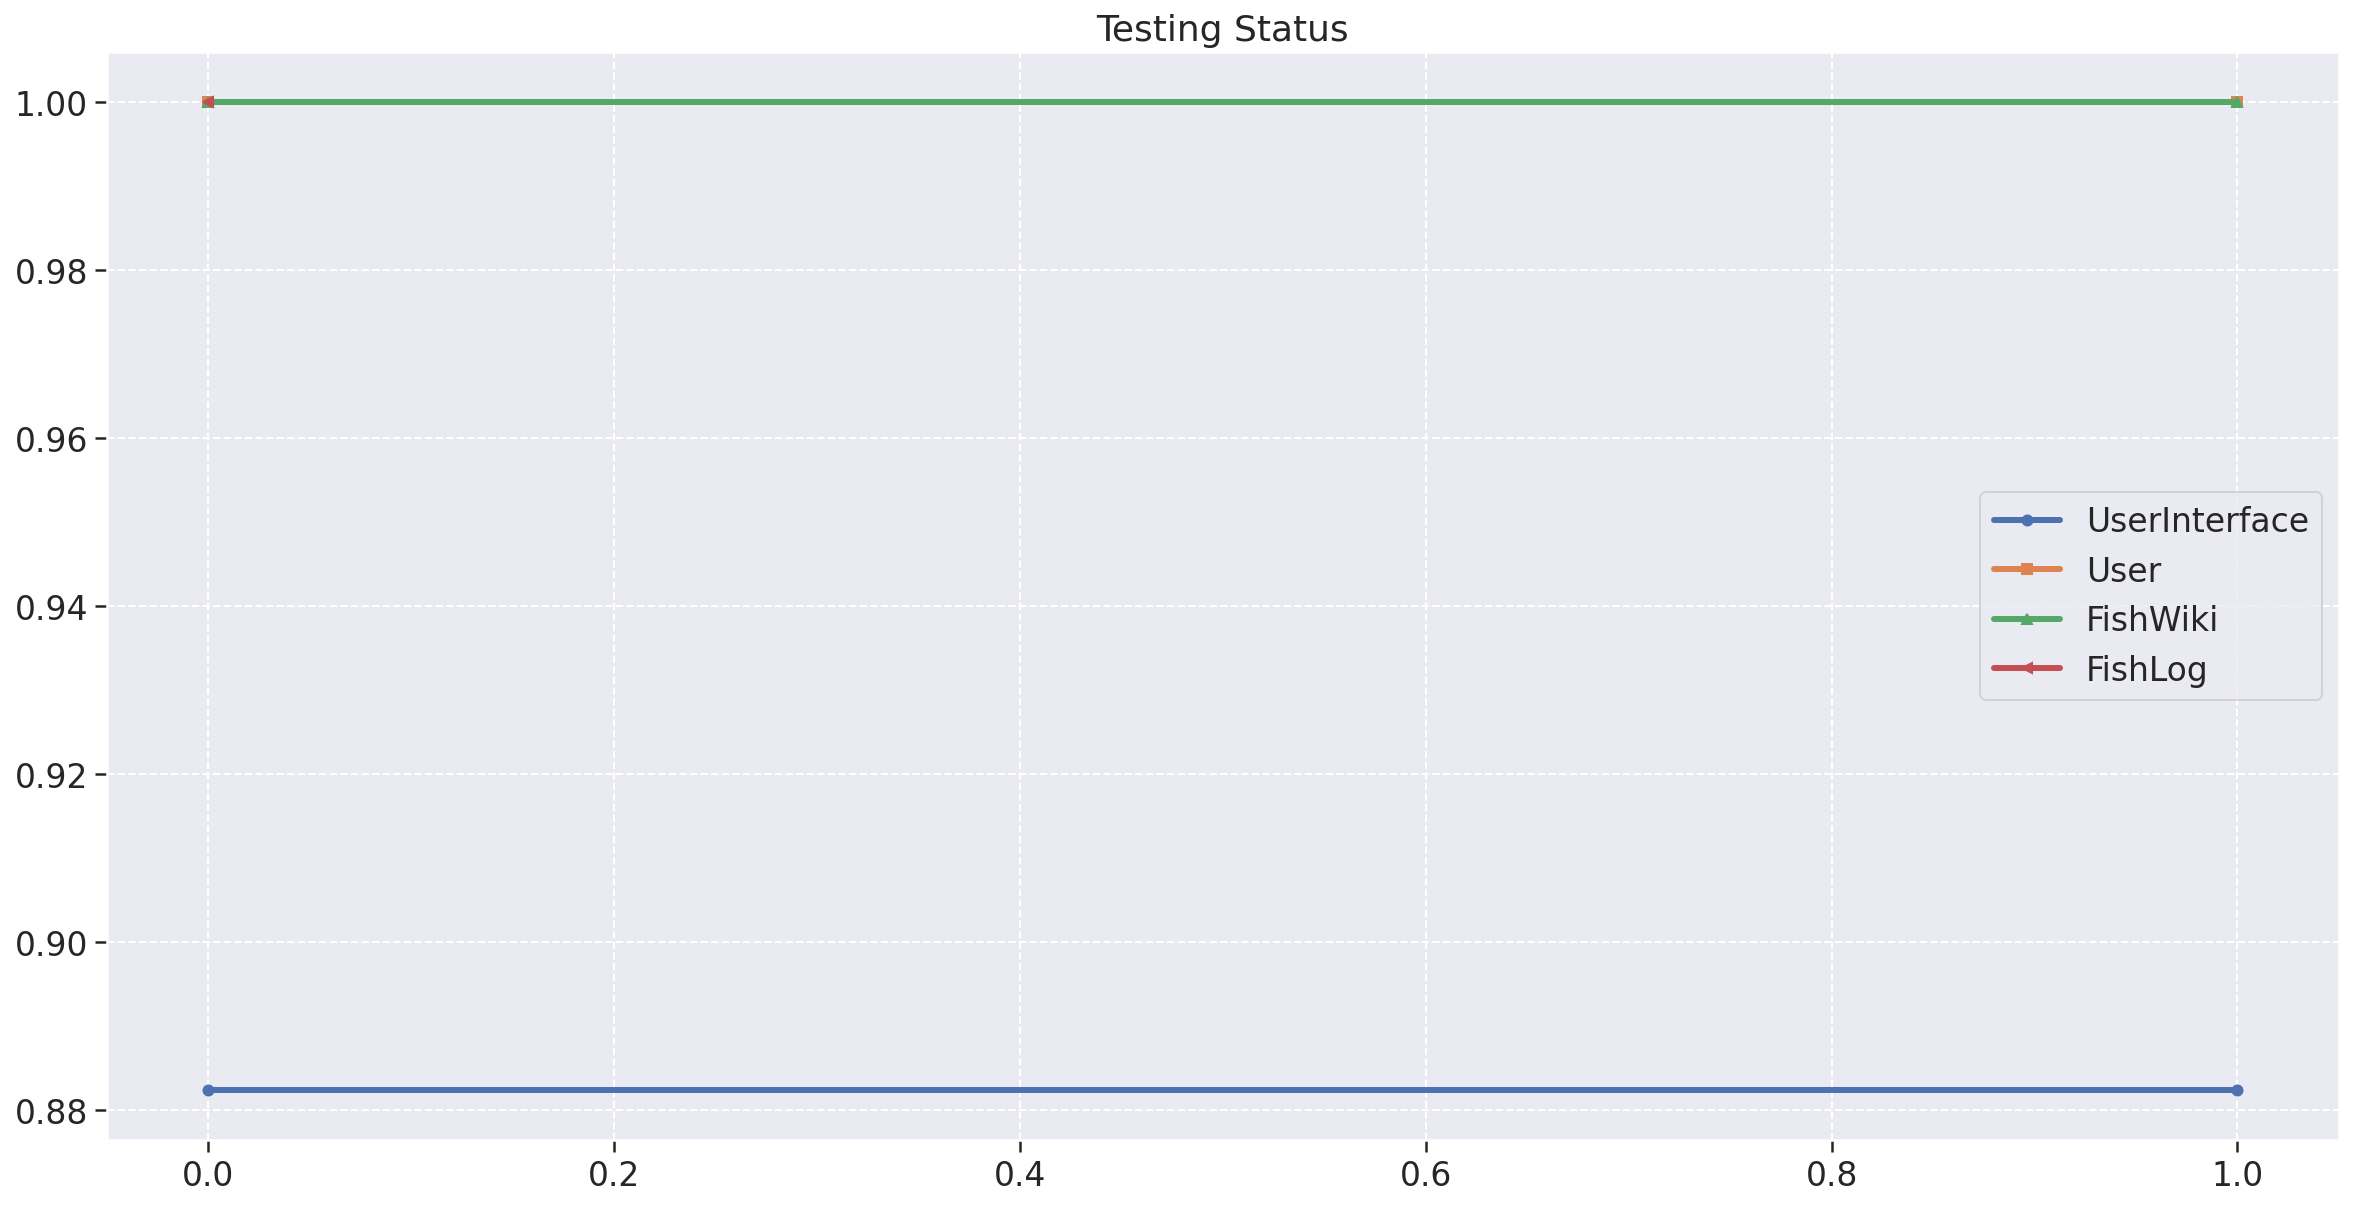

In [73]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

In [74]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['reliability']

In [75]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,reliability,total
0,0.870588,0.035294,0.882353,0.882353,0.882353,0.882353,UserInterface,03,5458,0.590118,0.882353,0.295059,0.441176,0.736235
1,0.870588,0.035294,0.882353,0.882353,0.882353,0.882353,UserInterface,04,10994,0.590118,0.882353,0.295059,0.441176,0.736235
2,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,03,209,0.618750,1.000000,0.309375,0.500000,0.809375
3,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,04,209,0.618750,1.000000,0.309375,0.500000,0.809375
4,0.625000,0.125000,1.000000,1.000000,1.000000,1.000000,FishWiki,03,343,0.577500,1.000000,0.288750,0.500000,0.788750
5,0.625000,0.125000,1.000000,1.000000,1.000000,1.000000,FishWiki,04,334,0.577500,1.000000,0.288750,0.500000,0.788750
6,0.625000,0.125000,1.000000,1.000000,1.000000,1.000000,FishLog,03,384,0.577500,1.000000,0.288750,0.500000,0.788750


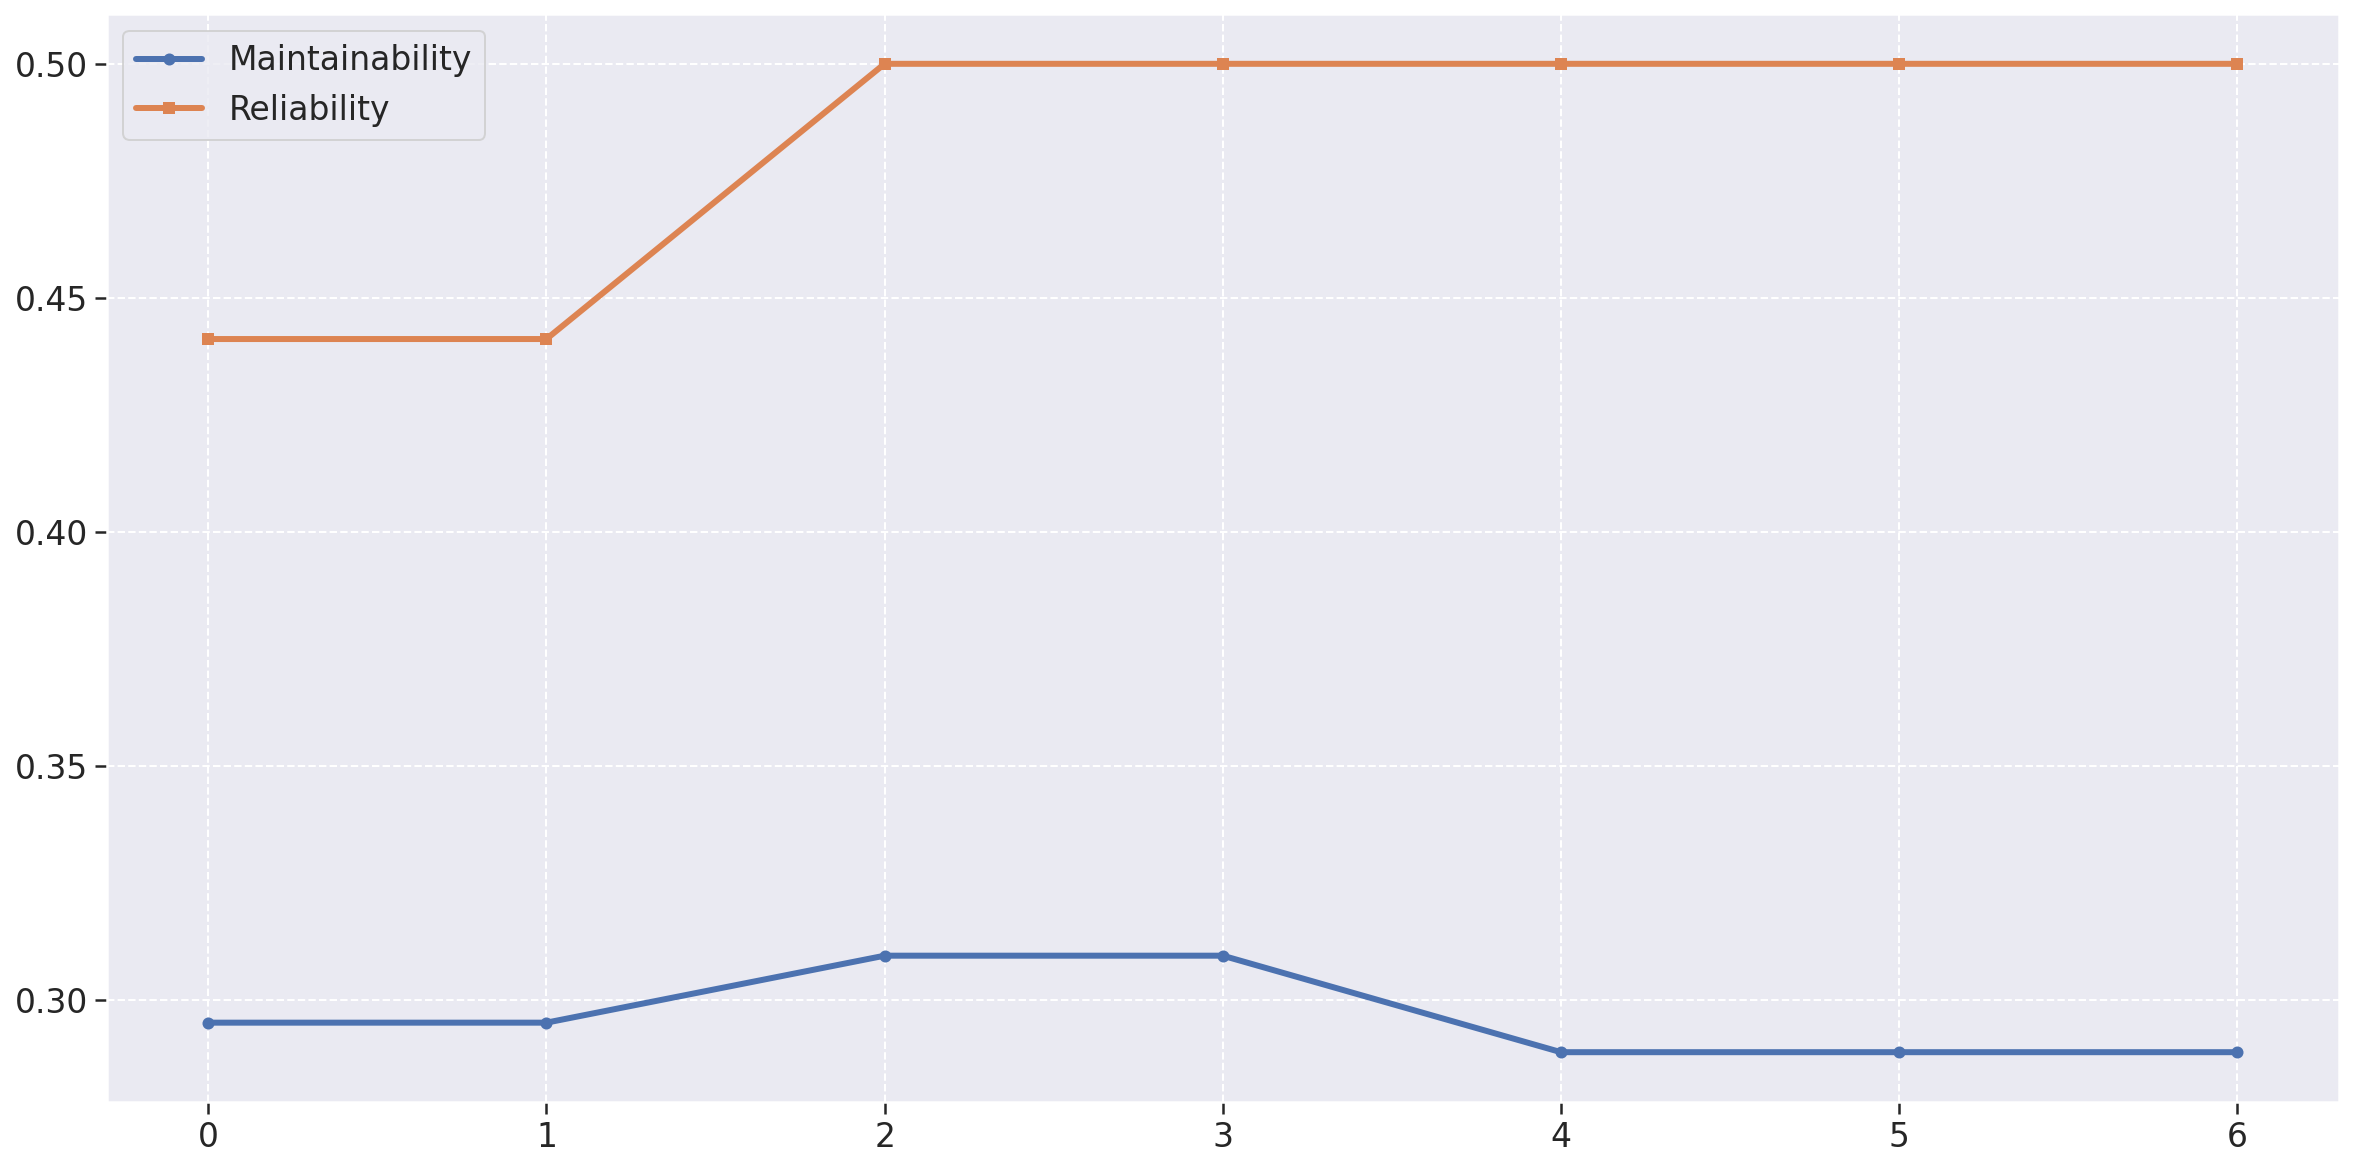

In [76]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.legend()

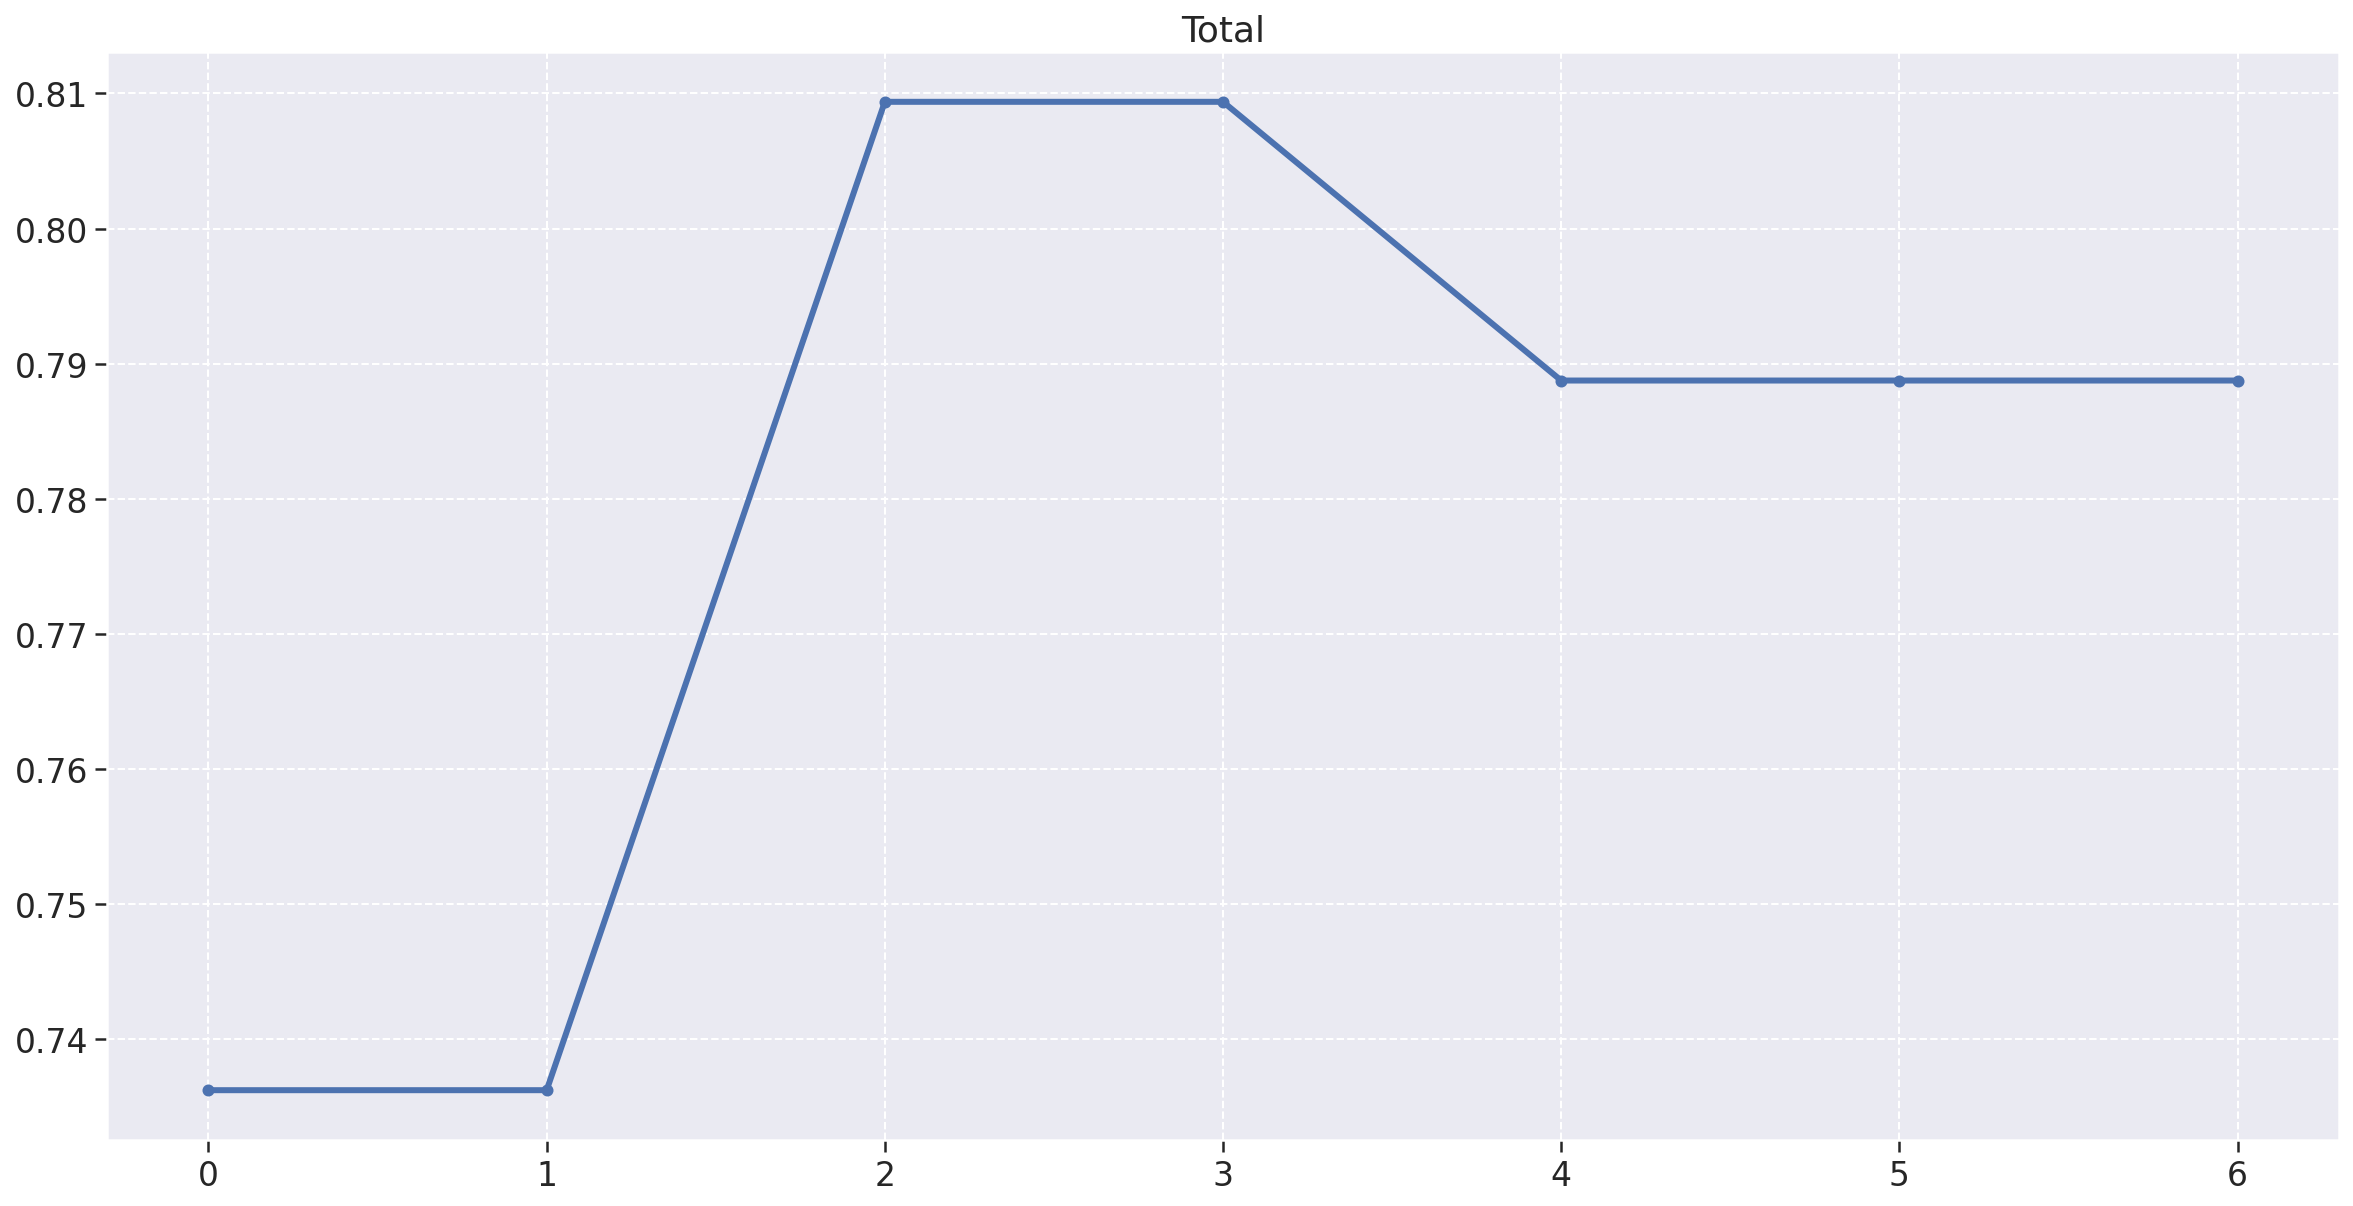

In [77]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)

In [78]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_csv('data/fga-eps-mds-2021_2-Eu_Pescador-{}.csv'.format(currentDateTime), index = False)